In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path as pth

In [3]:
import torch
import monai

In [4]:
import options
import data_utils
import local_unet

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# GradCAM implementation

In [27]:
def save_features(model, layers):
    features = {}
    for key, _ in layers:
        mod = dict(model.named_modules())[key]
        print(f'saving {key}')
        def save_output(module, input, output, name=key):
            features[name] = output
            output.requires_grad_()
            output.retain_grad()
        mod.register_forward_hook(save_output)
    return features

In [59]:
def gradcam(model, batch, layers, target_f, eps=1e-8, neg=False):
    result = dict(batch)
    features = save_features(model, layers)
    
    # forward model
    logits = model(batch['image'])
    result['preds'] = torch.sigmoid(logits)
    result['logits'] = logits

    # compute gradients
    target_f(model, logits, batch).backward(retain_graph=True)
    
    # compute gradcam
    for lkey, _ in layers:
        fmap = features[lkey]
        if fmap.grad is None:
            print(f'Layer {lkey} has no gradient and it should. Something is wrong.')
        gc = (fmap * fmap.grad.mean(dim=(2,3,4), keepdims=True)).sum(dim=1)
        if neg:
            gc = -gc
        gc = gc.relu()
        gc /= (gc.max() + eps)
        result[lkey] = gc
    for k in result:
        if torch.is_tensor(result[k]):
            result[k] = result[k].cpu().detach().numpy()
    return result

In [8]:
def target_entire_cls(label_ch):
    def f_(model, logits, batch):
        return logits[:, label_ch].mean(dim=(1,2,3)).sum(dim=0) # spatial mean, batch sum
    return f_

# Load model and data

In [9]:
args = options.parser.parse_args(['--model', 'unet', '--max-examples', '2', 'data/models/unet_longer/'])

In [10]:
stop_epoch = 600

In [11]:
train_ds, train_loader, val_ds, val_loader = data_utils.load_data(args, vis=True)

2/2 Load and cache transformed data:  [==============================]
2/2 Load and cache transformed data:  [==============================]


In [12]:
if args.model == 'unet':
    net = monai.networks.nets.UNet(
                dimensions=3,
                in_channels=4,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
            )
elif args.model == 'local_unet':
    net = local_unet.UNet(
                dimensions=3,
                in_channels=4,
                out_channels=3,
                channels=(16, 32, 64, 128, 256),
                strides=(2, 2, 2, 2),
                num_res_units=2,
            )    

In [13]:
checkpoint = torch.load(pth.join(args.model_dir, 'checkpoints', f'net_checkpoint_{stop_epoch}.pth'))
net.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [14]:
# device = torch.device("cuda:0")
# net = net.to(device)

In [15]:
batch = next(iter(val_loader))

# Choose layers to visualize

In [16]:
[k for k, v in net.named_modules()]

['',
 'model',
 'model.0',
 'model.0.conv',
 'model.0.conv.unit0',
 'model.0.conv.unit0.conv',
 'model.0.conv.unit0.norm',
 'model.0.conv.unit0.act',
 'model.0.conv.unit1',
 'model.0.conv.unit1.conv',
 'model.0.conv.unit1.norm',
 'model.0.conv.unit1.act',
 'model.0.residual',
 'model.1',
 'model.1.submodule',
 'model.1.submodule.0',
 'model.1.submodule.0.conv',
 'model.1.submodule.0.conv.unit0',
 'model.1.submodule.0.conv.unit0.conv',
 'model.1.submodule.0.conv.unit0.norm',
 'model.1.submodule.0.conv.unit0.act',
 'model.1.submodule.0.conv.unit1',
 'model.1.submodule.0.conv.unit1.conv',
 'model.1.submodule.0.conv.unit1.norm',
 'model.1.submodule.0.conv.unit1.act',
 'model.1.submodule.0.residual',
 'model.1.submodule.1',
 'model.1.submodule.1.submodule',
 'model.1.submodule.1.submodule.0',
 'model.1.submodule.1.submodule.0.conv',
 'model.1.submodule.1.submodule.0.conv.unit0',
 'model.1.submodule.1.submodule.0.conv.unit0.conv',
 'model.1.submodule.1.submodule.0.conv.unit0.norm',
 'model.1

In [17]:
net

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (norm): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (act): PReLU(num_parameters=1)
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (norm): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (act): PReLU(num_parameters=1)
        )
      )
      (residual): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0): Convolution(
              (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (norm

In [53]:
layers = [
# 'model',
# 'model.0.conv',
# 'model.0.conv.unit0',
# 'model.0.conv.unit0.conv',
# 'model.0.conv.unit0.norm',
# 'model.0.conv.unit0.act',
# 'model.0.conv.unit1',
# 'model.0.conv.unit1.conv',
# 'model.0.conv.unit1.norm',
# 'model.0.conv.unit1.act',
#   'model.0.residual',
('model.0', 'l1 high res'), # high res for concat 0
('model.1.submodule', 'l1 low res'), # low res for concat 0
('model.1', 'l1 output [high,low]'), # SkipConnection
('model.2', 'l1 final'),
# 'model.1.submodule.0.conv',
# 'model.1.submodule.0.conv.unit0',
# 'model.1.submodule.0.conv.unit0.conv',
# 'model.1.submodule.0.conv.unit0.norm',
# 'model.1.submodule.0.conv.unit0.act',
# 'model.1.submodule.0.conv.unit1',
# 'model.1.submodule.0.conv.unit1.conv',
# 'model.1.submodule.0.conv.unit1.norm',
# 'model.1.submodule.0.conv.unit1.act',
#   'model.1.submodule.0.residual',
('model.1.submodule.0', 'l2 high res'), # high res for concat 1
('model.1.submodule.1.submodule', 'l2 low res'), # low res for concat 1
('model.1.submodule.1', 'l2 output [high,low]'),
('model.1.submodule.2', 'l2 final'),
# 'model.1.submodule.1.submodule.0.conv',
# 'model.1.submodule.1.submodule.0.conv.unit0',
# 'model.1.submodule.1.submodule.0.conv.unit0.conv',
# 'model.1.submodule.1.submodule.0.conv.unit0.norm',
# 'model.1.submodule.1.submodule.0.conv.unit0.act',
# 'model.1.submodule.1.submodule.0.conv.unit1',
# 'model.1.submodule.1.submodule.0.conv.unit1.conv',
# 'model.1.submodule.1.submodule.0.conv.unit1.norm',
# 'model.1.submodule.1.submodule.0.conv.unit1.act',
#   'model.1.submodule.1.submodule.0.residual',
('model.1.submodule.1.submodule.0', 'l3 high res'), # high res for concat 2
('model.1.submodule.1.submodule.1.submodule', 'l3 low res'), # low res for concat 2
('model.1.submodule.1.submodule.1', 'l3 output [high,low]'),
('model.1.submodule.1.submodule.2', 'l3 final'),
# 'model.1.submodule.1.submodule.1.submodule.0.conv',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit0',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit0.conv',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit0.norm',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit0.act',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit1',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit1.conv',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit1.norm',
# 'model.1.submodule.1.submodule.1.submodule.0.conv.unit1.act',
# 'model.1.submodule.1.submodule.1.submodule.0.residual',
('model.1.submodule.1.submodule.1.submodule.0', 'l4 high res'), # high res for concat 3
('model.1.submodule.1.submodule.1.submodule.1.submodule', 'l4 low res'), # low res for concat 3
('model.1.submodule.1.submodule.1.submodule.1', 'l4 output [high,low]'),
('model.1.submodule.1.submodule.1.submodule.2', 'l4 final'),
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.conv',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.norm',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit0.act',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.conv',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.norm',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.conv.unit1.act',
# 'model.1.submodule.1.submodule.1.submodule.1.submodule.residual',
# 'model.1.submodule.1.submodule.1.submodule.2.0',
# 'model.1.submodule.1.submodule.1.submodule.2.0.conv',
# 'model.1.submodule.1.submodule.1.submodule.2.0.norm',
# 'model.1.submodule.1.submodule.1.submodule.2.0.act',
# 'model.1.submodule.1.submodule.1.submodule.2.1',
# 'model.1.submodule.1.submodule.1.submodule.2.1.conv',
# 'model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0',
# 'model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.conv',
# 'model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.norm',
# 'model.1.submodule.1.submodule.1.submodule.2.1.conv.unit0.act',
# 'model.1.submodule.1.submodule.1.submodule.2.1.residual',
# 'model.1.submodule.1.submodule.2.0',
# 'model.1.submodule.1.submodule.2.0.conv',
# 'model.1.submodule.1.submodule.2.0.norm',
# 'model.1.submodule.1.submodule.2.0.act',
# 'model.1.submodule.1.submodule.2.1',
# 'model.1.submodule.1.submodule.2.1.conv',
# 'model.1.submodule.1.submodule.2.1.conv.unit0',
# 'model.1.submodule.1.submodule.2.1.conv.unit0.conv',
# 'model.1.submodule.1.submodule.2.1.conv.unit0.norm',
# 'model.1.submodule.1.submodule.2.1.conv.unit0.act',
# 'model.1.submodule.1.submodule.2.1.residual',
# 'model.1.submodule.2.0',
# 'model.1.submodule.2.0.conv',
# 'model.1.submodule.2.0.norm',
# 'model.1.submodule.2.0.act',
# 'model.1.submodule.2.1',
# 'model.1.submodule.2.1.conv',
# 'model.1.submodule.2.1.conv.unit0',
# 'model.1.submodule.2.1.conv.unit0.conv',
# 'model.1.submodule.2.1.conv.unit0.norm',
# 'model.1.submodule.2.1.conv.unit0.act',
# 'model.1.submodule.2.1.residual',
# 'model.2.0',
# 'model.2.0.conv',
# 'model.2.0.norm',
# 'model.2.0.act',
# 'model.2.1',
# 'model.2.1.conv',
# 'model.2.1.conv.unit0',
# 'model.2.1.conv.unit0.conv',
# 'model.2.1.residual',
]

# Visualize

In [19]:
def show_input_output(gcam_result, exi=0, slice=30):
    plt.figure(figsize=(15, 10))

    for in_ch in range(4):
        plt.subplot(3, 4, in_ch + 1)
        plt.imshow(gcam_result['vis_image'][exi, in_ch, :, :, slice])
        plt.title(f'input ch={in_ch}')
        plt.axis('off')
        
    for label_ch in range(3):
        plt.subplot(3, 4, 5 + label_ch)
        plt.imshow(gcam_result['seg'][exi, label_ch, :, :, slice])
        plt.title(f'label ch={label_ch}')
        plt.axis('off')
        
        plt.subplot(3, 4, 9 + label_ch)
        plt.imshow(gcam_result['preds'][exi, label_ch, :, :, slice])
        plt.title(f'pred ch={label_ch}')
        plt.axis('off')
        
    plt.tight_layout()

In [62]:
def show_gradcam(gcam_result, exi, slice, label_ch, layers):
    plt.figure(figsize=(15, 10))
    rows = 5

    for in_ch in range(4):
        plt.subplot(rows, 5, in_ch + 1)
        plt.imshow(gcam_result['vis_image'][exi, in_ch, :, :, slice])
        plt.title(f'input ch={in_ch}')
        plt.axis('off')

    plt.subplot(rows, 5, 5)
    plt.imshow(gcam_result['preds'][exi, label_ch, :, :, slice])
    plt.title(f'pred for label={label_ch}')
    plt.axis('off')

    plti = 0
    for i, layer in enumerate(layers):
        lkey, lname = layer
        plt.subplot(rows, 5, 6+plti)
        plti += 1 if ((i + 1) % 4) > 0 else 2
        layer_slice = int(gcam_result[lkey].shape[-1] * slice_ratio)
        plt.imshow(gcam_result[lkey][exi, :, :, layer_slice])
        plt.title(f'gradcam of entire output w.r.t.\n{lname}')
        plt.axis('off')

    plt.tight_layout()

In [21]:
slice_ratio = 0.6
slice = int(batch['image'].shape[-1] * slice_ratio)
exi = 0
label_ch = 2

In [68]:
for k, v in gcam_result.items():
    if hasattr(v, 'shape'):
        print(k, v.shape)

seg (2, 3, 128, 128, 64)
image (2, 4, 128, 128, 64)
vis_image (2, 4, 128, 128, 64)
preds (2, 3, 128, 128, 64)
logits (2, 3, 128, 128, 64)
model.0 (2, 64, 64, 32)
model.1.submodule (2, 64, 64, 32)
model.1 (2, 64, 64, 32)
model.2 (2, 128, 128, 64)
model.1.submodule.0 (2, 32, 32, 16)
model.1.submodule.1.submodule (2, 32, 32, 16)
model.1.submodule.1 (2, 32, 32, 16)
model.1.submodule.2 (2, 64, 64, 32)
model.1.submodule.1.submodule.0 (2, 16, 16, 8)
model.1.submodule.1.submodule.1.submodule (2, 16, 16, 8)
model.1.submodule.1.submodule.1 (2, 16, 16, 8)
model.1.submodule.1.submodule.2 (2, 32, 32, 16)
model.1.submodule.1.submodule.1.submodule.0 (2, 8, 8, 4)
model.1.submodule.1.submodule.1.submodule.1.submodule (2, 8, 8, 4)
model.1.submodule.1.submodule.1.submodule.1 (2, 8, 8, 4)
model.1.submodule.1.submodule.1.submodule.2 (2, 16, 16, 8)


In [60]:
gcam_result = gradcam(net, batch, layers, target_entire_cls(label_ch), neg=True)

saving model.0
saving model.1.submodule
saving model.1
saving model.2
saving model.1.submodule.0
saving model.1.submodule.1.submodule
saving model.1.submodule.1
saving model.1.submodule.2
saving model.1.submodule.1.submodule.0
saving model.1.submodule.1.submodule.1.submodule
saving model.1.submodule.1.submodule.1
saving model.1.submodule.1.submodule.2
saving model.1.submodule.1.submodule.1.submodule.0
saving model.1.submodule.1.submodule.1.submodule.1.submodule
saving model.1.submodule.1.submodule.1.submodule.1
saving model.1.submodule.1.submodule.1.submodule.2


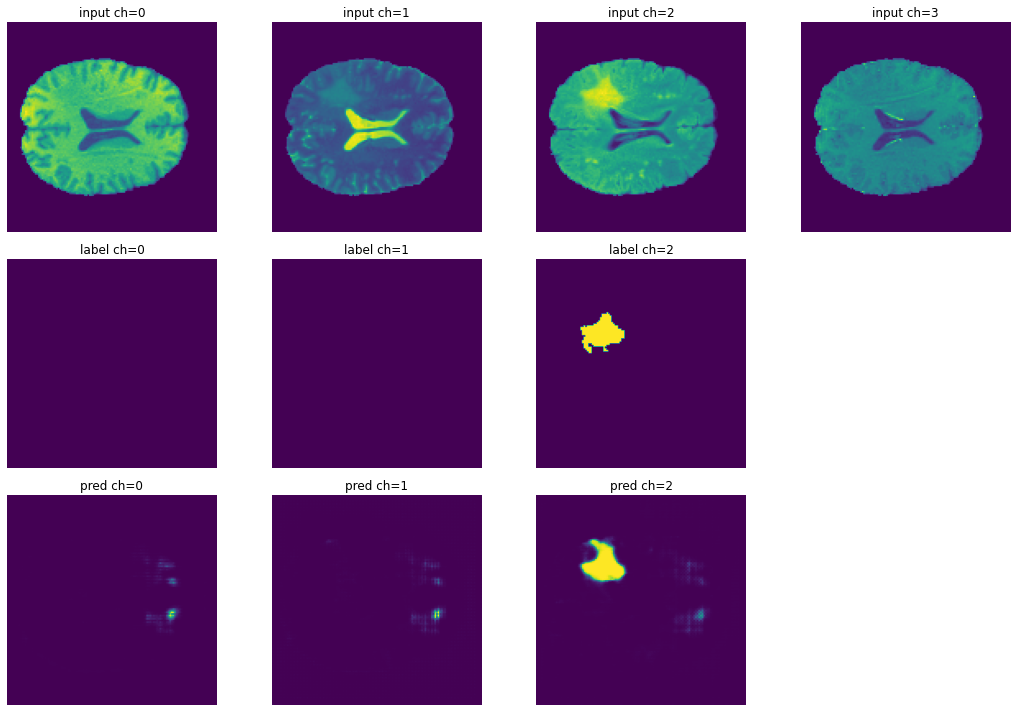

In [44]:
show_input_output(gcam_result, exi, slice)

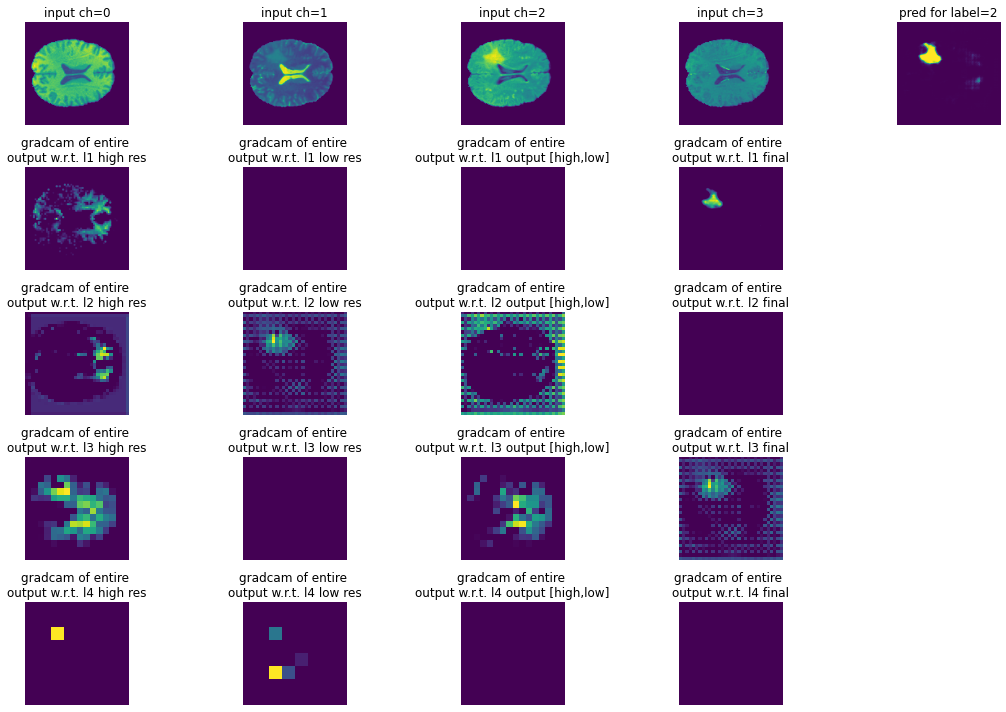

In [55]:
show_gradcam(gcam_result, exi, slice, label_ch=label_ch, layers=layers)

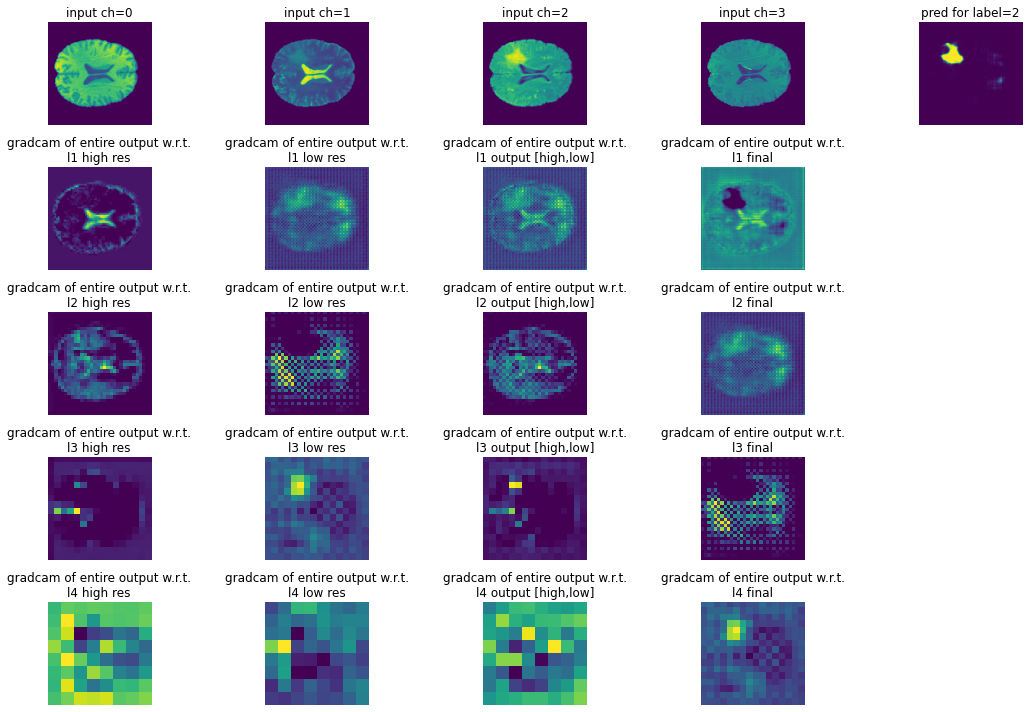

In [63]:
show_gradcam(gcam_result, exi, slice, label_ch=label_ch, layers=layers)